In this example, we will consider the conversion in the AGN jet and the Galactic mangetic field. We will use the source 3C454.3, a flat spectrum radio quasar from which giant flares at $\gamma$-ray energies were detected with the Fermi LAT. The magnetic fields assumed for the blazar are taken from Kutkin et al. (2014), http://adsabs.harvard.edu/abs/2014MNRAS.437.3396K 

## Imports

We start with the usual imports

In [1]:
from gammaALPs import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c
from matplotlib.patheffects import withStroke
from astropy import units as u

In [2]:
effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])

In [3]:
%matplotlib inline

## Defining the source

Next we set up the source parameters, taken e.g. from NED, http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=3C454.3&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES

In [4]:
src = Source(z = 0.859000, ra = '22h53m57.7s', dec = '+16d08m54s',
            bLorentz = 15.6, theta_obs = 1.3) # 3C454.3
#src = Source(z = 0.4, ra = '15h55m43.0440s', dec = '+11d11m24.365s', bLorentz = 15.64, theta_obs = np.rad2deg(1./15.64))
print (src.z)
print (src.ra, src.dec)
print (src.l, src.b)
print (src._doppler)

0.859
-38.1836097158645 16.148333333333333
86.11095204202921 -38.1836097158645
27.707499216562937


Note that we also provide the bulk Lorentz factor $\Gamma = 15.6$ and the observation angle in degrees, $\theta = 1.3^\circ$, according to Kutkin et al., who used average values from Jorstad et al. (2005). These values yield the Doppler factor, $\delta \sim 27.7$.

### Init the module list

Now we set up the module list with some arbitrary ALP parameters. The energy range is motivated from the Fermi-LAT energy range.

In [5]:
EGeV = np.logspace(-2,4.,2000)
#EGeV = np.logspace(1., 5., 2000)

Here's the initial polarization matrix, again we assume an unpolarized beam.

In [6]:
pin = np.diag((1.,1.,0.)) * 0.5

In [7]:
m = ModuleList(ALP(m = 1., g = 2.), src, pin = pin, EGeV = EGeV, seed = 0)

Now add the modules:

In [8]:
gamma_min = 1.
m.add_propagation("Jet", 
                  0, # position of module counted from the source. 
                  B0 = 0.32, #Jet field at r = R0 in G 
                  r0 = 1., #distance from BH where B = B0 in pc
                  rgam = 3.19e17 * u.cm.to('pc'), # distance of gamma-ray emitting region to BH
                  alpha = -1, #exponent of toroidal mangetic field (default: -1.)
                  psi = np.pi/4., #Angle between one photon polarization state and B field. 
                          #Assumed constant over entire jet. 
                  helical = True, #if True, use helical magnetic-field model from Clausen-Brown et al. (2011). 
                                    #In this case, the psi kwarg is treated is as the phi angle 
                                    #of the photon trajectory in the cylindrical jet coordinate system
                  equipartition = True, #if true, assume equipartition between electrons and the B field. 
                            #This will overwrite the exponent of electron density beta = 2 * alpha 
                            #and set n0 given the minimum electron lorentz factor set with gamma_min
                  gamma_min = gamma_min, #minimum lorentz factor of emitting electrons, only used if equipartition = True
                  gamma_max = np.exp(10.) * gamma_min, #maximum lorentz factor of emitting electrons, only used if equipartition = True
                  Rjet = 40., #maximum jet length in pc (default: 1000.)
                  n0 = 1e4, beta = -2.
                 )
m.add_propagation("EBL",1, eblmodel = 'dominguez') # EBL attenuation comes second, after beam has left cluster
m.add_propagation("GMF",2, model = 'jansson12', model_sum = 'ASS') # finally, the beam enters the Milky Way Field

### Peek at the electron density and the magnetic field

3124.111527961476 39.799214583594626


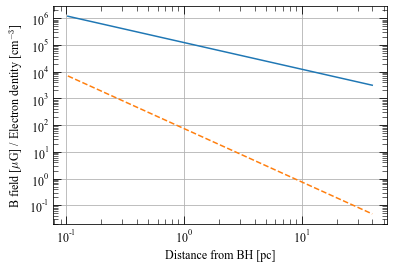

In [9]:
plt.loglog(m.modules[0]._r, m.modules[0].B)
plt.loglog(m.modules[0]._r, m.modules[0].nel, color = plt.cm.tab10(0.1), ls = '--')
plt.grid(True)
plt.xlabel('Distance from BH [pc]')
plt.ylabel('B field [$\mu$G] / Electron dentity [cm$^{-3}$]')
print (m.modules[0].B[-1],m.modules[0]._r[-1])
#print (m.modules[0]._spp)
#print (m.modules[0]._cpp)

### Compute the photon-ALP mixing probability

Set the ALP values

In [89]:
m.alp.m = 100.
m.alp.g = 0.3

In [90]:
px,py,pa = m.run(multiprocess=2)

### Plot the output

In [91]:
atten = np.exp(-m.modules[1].opt_depth(src.z, m.EGeV / 1e3))

(1, 2000)
1.1526168455103961e-08 1.081570326818511e-08


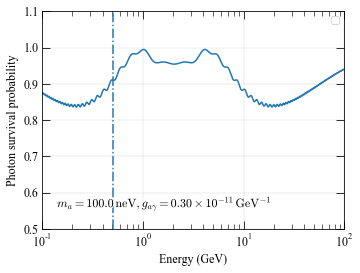

In [92]:
pgg = px + py # the total photon survival probability
#pgg = pa
print (pgg.shape)
#print (np.max(pgg[0][m.EGeV < 1.]) - np.min(pgg[0][m.EGeV < 1.]))
print (px[0,-1], py[0,-1])

for p in pgg: # plot all realizations
    plt.plot(m.EGeV, p / atten)
    #plt.plot(m.EGeV, p )

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

#plt.plot(m.EGeV, atten)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')
plt.legend(loc = 0, fontsize = 'medium')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
             xy = (0.05,0.1), size = 'large', xycoords = 'axes fraction', ha = 'left',**effect)


plt.axvline(transfer.EminGeV(m.alp.m, m.alp.g, m.modules[0].nel[0], m.modules[0].B[0]), ls = '--')
plt.axvline(transfer.EminGeV(m.alp.m, m.alp.g, m.modules[-1].nel[-1], m.modules[-1].B[-1]), ls = ':')
plt.axvline(transfer.EmaxGeV(m.alp.g, m.modules[0].B[0]), ls = '-.')
plt.gca().set_ylim(0.5,1.1)
plt.gca().set_xlim(1e-1,1e2)
#plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)
plt.savefig("Pgg.png", dpi = 200)

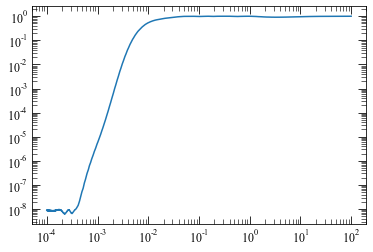

In [76]:
for p in pgg: # plot all realizations
    plt.loglog(1./m.EGeV, p)

In [69]:
mask = m.EGeV < 10.
ft = np.fft.fft((pgg[0] / atten)[mask])
ff = np.fft.fftfreq((pgg[0][mask].shape[0]))
t = np.arange(1.,256)
fs = np.fft.fft(np.sin(t))
ffs = np.fft.fftfreq(t.shape[0])

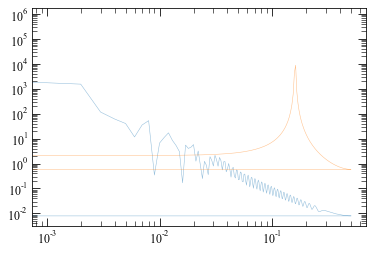

In [71]:
plt.loglog(ff, np.real(ft * ft.conjugate()), ls = '-', lw = 0.5, marker = 'None', alpha = 0.5)
plt.loglog(ffs, np.real(fs * fs.conjugate()), ls = '-', lw = 0.5, marker = 'None', alpha = 0.5)#